# Decomposição Viés-Variância

A decomposição viés-variância (no inglês [bias–variance decomposition](http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp)) é uma forma de analisar o erro de generalização esperado de um algoritmo de aprendizagem em relação a um problema específico como uma soma de três termos: **bias** (viés), **variance** (variância) e **noise** (erro irredutível). 


- **Bias** (Viés): É um erro de premissas errôneas durante o aprendizado do algoritmo. 
- **Variance** (Variância): É um erro de sensibilidade a pequenas flutuações no conjunto de treinamento.
- **Noise** (Erro Irredutível): É um erro resultante do ruído do próprio problema que não é possível eliminar.

$$
\text{Error} = \text{Bias}(\hat\theta) + \text{Var}(\hat\theta) + \text{Noise}
$$

# Ilustração Viés-Variância

- **High Bias** (Alto Viés): É quando o modelo <ins>assume premissas simples demais</ins> durante o aprendizado do algoritmo. 
- **Low Bias** (Baixo Viés): É quando o modelo <ins>assume premissas específicas demais</ins> durante o aprendizado do algoritmo. 
- **High Variance** (Alta Variância): É quando o modelo <ins>considera qualquer flutuação nos dados</ins> (inclusive ruídos) durante o aprendziado do algoritmo.
- **Low Variance** (Baixa Variância): É quando o modelo <ins>desconsidera qualquer flutuação nos dados</ins> durante o aprendizado do algoritmo.


<img src="bias-variance-tradeoff.svg" width="500"> 

# Relação de Viés-Variância com Subajuste e Sobreajuste

- **Underfitting** (Subajuste)
 - Ocorre quando um algoritmo perde as relações relevantes entre as características e o objetivo desejado.
 - É caracterizado por um <ins>high bias</ins> (alto viés) e <ins>low variance</ins> (baixa variância).

- **Overfitting** (Sobreajuste)
 - Ocorre quando um algoritmo aprende os ruídos do conjunto de treinamento.
 - É caracterizado por um <ins>low bias</ins> (baixo viés) e <ins>high variance</ins> (alta variância).

- **Best fitting** (Melhor Ajuste)
  - Ocorre quando um algoritmo aprende as relações relevantes entre as características e o objetivo desejado considerando adequadamente as flutuações dos dados tornando seu aprendizado generalizável para futuras observações.
  - É caracterizado por <ins>low bias</ins> (baixo viés) e <ins>low variance</ins> (baixa variância).

![](bias-variance-curve.png)

# Exemplo Prático

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp

In [2]:
def make_dataset(problem, n_samples, random_state, plot):
    """ Gera conjunto de dados artificiais """
    if problem == 'classification':
        X, y = make_classification(
            n_samples=n_samples,
            n_features=2,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=2,
            class_sep=0.1,
            random_state=random_state)

        if plot:
            plt.subplots(figsize=(20, 4))
            df = pd.DataFrame({"x0": X[:,0], "x1": X[:,1], "y": y})
            ax = sns.scatterplot(data=df, x="x0", y="x1", hue="y")
            ax.set_title(f"random_state={random_state}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.show()

    if problem == 'regression':
        start, stop, step = 0, 2 * np.pi, 0.1
        size = int(np.round((stop - start) / step))
        np.random.seed(random_state)
        
        noise = np.random.normal(loc=0, scale=0.3, size=size)
        X = np.reshape(np.arange(start=start, stop=stop, step=step), (size, 1))
        y = np.sin(X[:,0]) + noise
        
        if plot:
            plt.subplots(figsize=(20, 4))
            ax = sns.scatterplot(data=pd.DataFrame({"x": X[:,0], "y": y}), x="x", y="y")
            ax.set_title(f"random_state={random_state}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.show()

    return X, y

In [3]:
def model_benchmark(X, y, problem, model):
    """ Realiza experimentação de bias-variance variando 10 niveis de complexidade """
    
    assert problem in ['classification', 'regression']
    assert model in ['tree', 'linear']
    
    # Variavel que irá armazenar os resultados de cada iteração do experimento
    benchmark = {
        "loss"      : [],
        "bias"      : [],
        "variance"  : [],
        "score"     : [],
        "complexity": []
    }
    
    # Define o parametro de estratificação caso seja um problema de classificação
    stratify = y if problem == 'classification' else None
    
    # Divide o conjunto de dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=stratify)
    
    # Define a complexidade inicial do modelo. A complexidade máxima é determinada abaixo,
    # considerando o número total de subplots (neste caso será 10)
    complexity = 1
    
    # Cria 10 subplots (2 linhas de 5 colunas) para exibir as linhas de decisão para cada complexidade
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20, 5))
    
    # Para cada subplot, treina o modelo, aplica a decomposição vies-variancia,
    # armazena os resultados e plota a visualização no subplot
    for ax in axes.flatten():
        
        if problem == 'classification':
            loss = "0-1_loss"
            if model == 'tree':
                mdl = DecisionTreeClassifier(max_depth=complexity, random_state=1)
            elif model == 'linear':
                mdl = Pipeline([
                    ('poly', PolynomialFeatures(degree=complexity)),
                    ('lr', LogisticRegression(solver='saga'))
                ])
        elif problem == 'regression':
            loss = "mse"
            if model == 'tree':
                mdl = DecisionTreeRegressor(max_depth=complexity, random_state=1)
            elif model == 'linear':
                mdl = Pipeline([
                    ('poly', PolynomialFeatures(degree=complexity)),
                    ('lr', LinearRegression())
                ])

        mdl = mdl.fit(X_train, y_train)
        loss, bias, var = bias_variance_decomp(mdl, X_train, y_train, X_test, y_test, loss=loss, random_seed=0)
        score = mdl.score(X_train, y_train)
        y_pred = mdl.predict(X_train) # queremos saber a predicao durante treinamento

        benchmark["loss"].append(loss)
        benchmark["bias"].append(bias)
        benchmark["variance"].append(var)
        benchmark["score"].append(score)
        benchmark["complexity"].append(complexity)

        
        if problem == 'classification':
            plot_decision_regions(X_train, y_train, clf=mdl, ax=ax)
            ax.set_title(f"complexity={complexity}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        elif problem =='regression':
            data = pd.DataFrame({"x": X_train[:,0], "y_true": y_train, "y_pred": y_pred})
            sns.scatterplot(data=data, x="x", y="y_true", ax=ax)
            sns.lineplot(data=data, x="x", y="y_pred", color="red", ax=ax)
            ax.set_title(f"complexity={complexity}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        complexity += 1

    # Plota a regiao de decisao (classificacao) e ajuste (regressao) de todos subplots (cada complexidade)
    plt.show()
    
    data = pd.DataFrame(benchmark)
    
    # Plota o bias-variance tradeoff e destaca 
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 5))
    sns.lineplot(x="complexity", y="bias", color="blue", data=data, ax=axes[0], legend='brief', label='bias')   
    sns.lineplot(x="complexity", y="variance", color="green", data=data, ax=axes[0].twinx(), legend='brief', label='variance')
    sns.lineplot(x="complexity", y="loss", color="red", data=data, ax=axes[1], legend='brief', label='loss')
    axes[0].set_title("Bias-Variance Tradeoff")
    axes[1].set_title("Model Loss")
    plt.show()


 ## Classificação

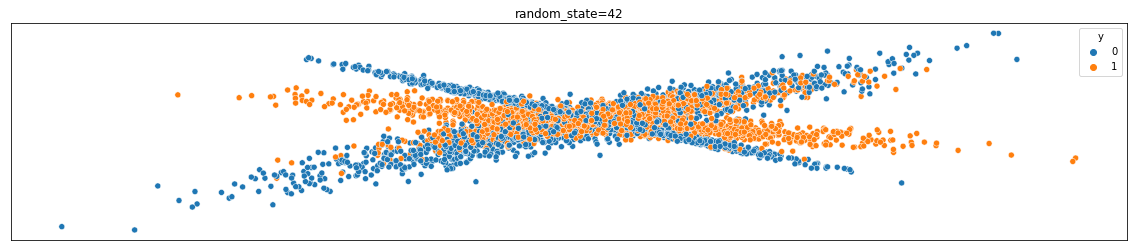

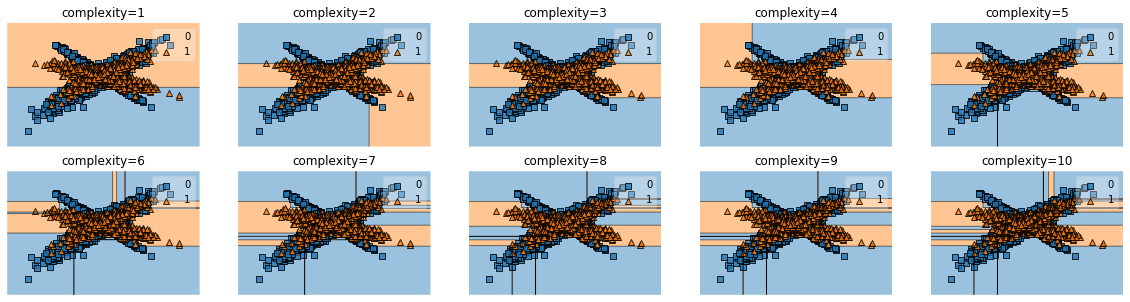

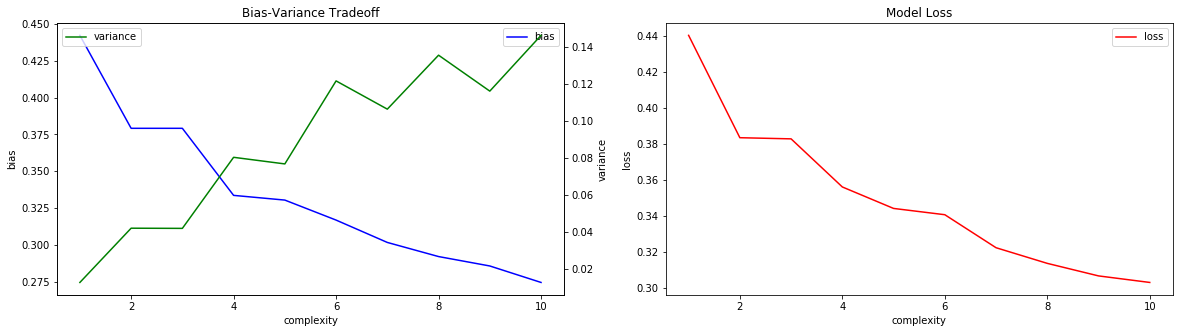

In [4]:
problem = 'classification'
X, y = make_dataset(problem=problem, n_samples=5000, random_state=42, plot=True)
model_benchmark(X, y, problem=problem, model='tree')

## Regressão

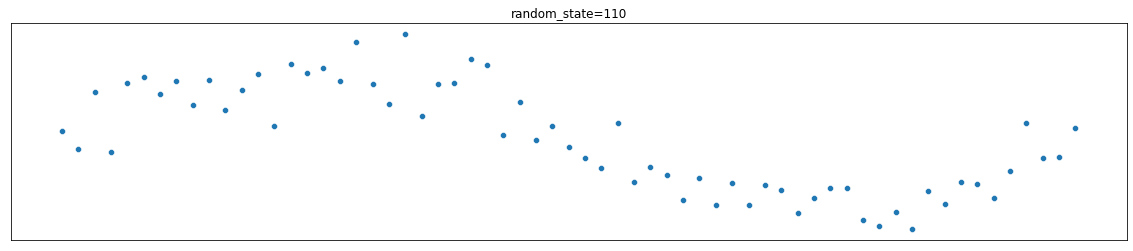

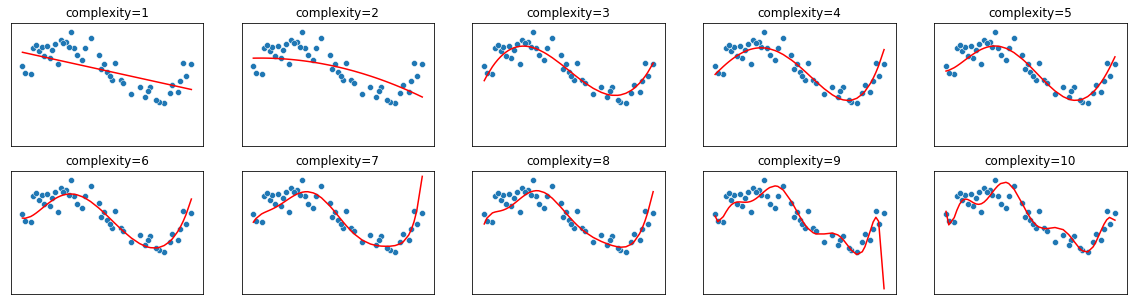

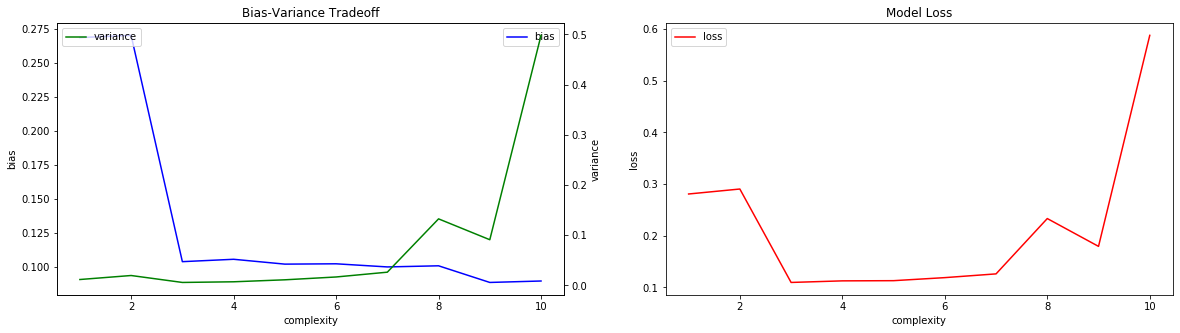

In [104]:
problem = 'regression'
X, y = make_dataset(problem=problem, n_samples=5000, random_state=110, plot=True)
model_benchmark(X, y, problem=problem, model='linear')

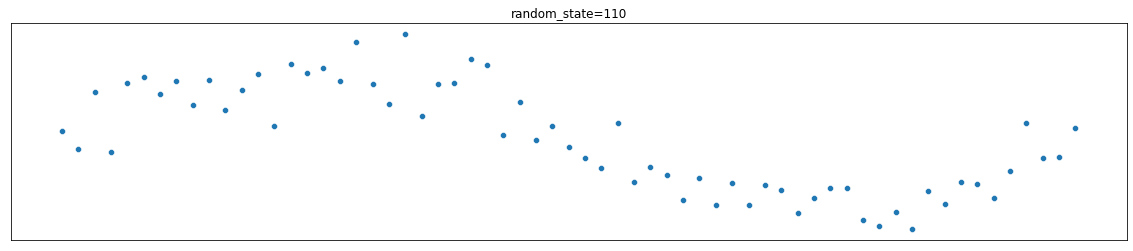

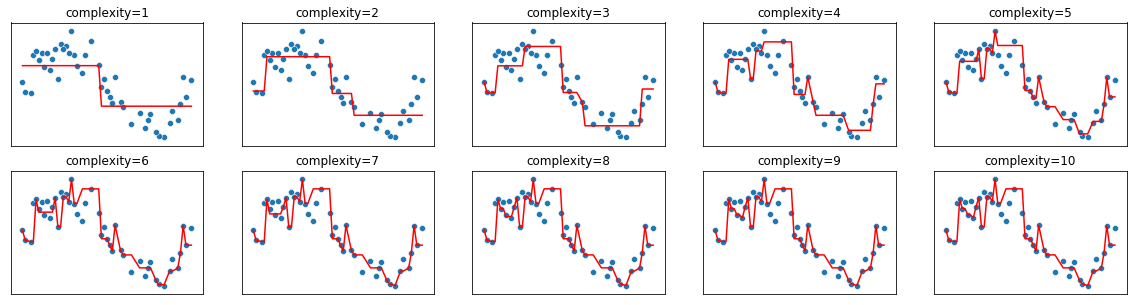

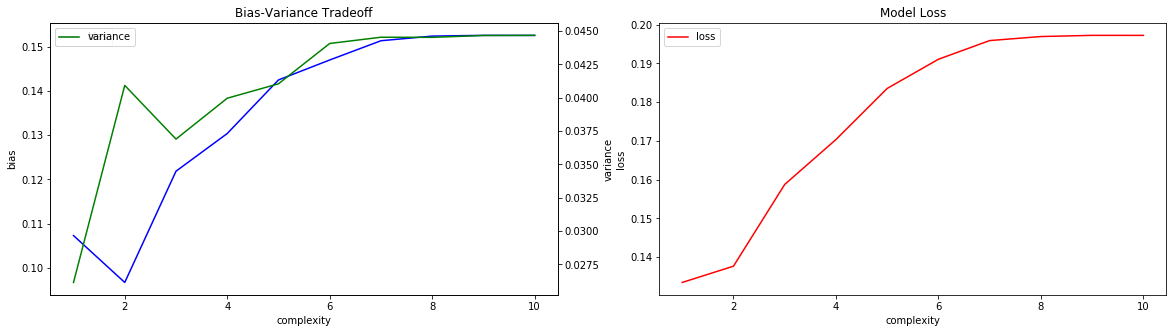

In [5]:
problem = 'regression'
X, y = make_dataset(problem=problem, n_samples=5000, random_state=110, plot=True)
model_benchmark(X, y, problem=problem, model='tree')